## Cluster Analysis

In [ ]:
# Libraries
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import plotly.graph_objs as go
import re
import string
from wordcloud   import WordCloud, STOPWORDS
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read Flamingo Data

In [ ]:
path = "/content/drive/MyDrive/BCU/Assignment_Flamingo/"

In [ ]:
df_adclicks = pd.read_csv(path+'/DataSet/flamingo-data/ad-clicks.csv')
df_buyclicks = pd.read_csv(path+'/DataSet/flamingo-data/buy-clicks.csv')


**Dataset ad_clicks.csv**


In [ ]:
df_adclicks.head()

,timestamp,txId,userSessionId,teamId,userId,adId,adCategory
0,2016-05-26 15:13:22,5974,5809,27,611,2,electronics
1,2016-05-26 15:17:24,5976,5705,18,1874,21,movies
2,2016-05-26 15:22:52,5978,5791,53,2139,25,computers
3,2016-05-26 15:22:57,5973,5756,63,212,10,fashion
4,2016-05-26 15:22:58,5980,5920,9,1027,20,clothing


**Dataset buy-clicks.csv**

In [ ]:
df_buyclicks.head()

,timestamp,txId,userSessionId,team,userId,buyId,price
0,2016-05-26 15:36:54,6004,5820,9,1300,2,3.0
1,2016-05-26 15:36:54,6005,5775,35,868,4,10.0
2,2016-05-26 15:36:54,6006,5679,97,819,5,20.0
3,2016-05-26 16:36:54,6067,5665,18,121,2,3.0
4,2016-05-26 17:06:54,6093,5709,11,2222,5,20.0


### Features Selection

In [ ]:
# Sum the total number of ads per user and rename the columns to be called 'userId' and 'totalAdClicks'.

user_adclicks = df_adclicks.groupby('userId').size().reset_index(name='totalAdClicks')
user_adclicks.head()

,userId,totalAdClicks
0,1,44
1,8,10
2,9,37
3,10,19
4,12,46


In [ ]:
#Select userid and price from df_buyclicks as an attribute that captures user's purchasing behavior

user_purchases = df_buyclicks[['userId','price']]
user_purchases.head(5)

,userId,price
0,1300,3.0
1,868,10.0
2,819,20.0
3,121,3.0
4,2222,20.0


In [ ]:
# Total money spent by each user and rename the columns to be called 'userId' and 'revenue'

revenue_per_user = user_purchases.groupby('userId').agg(['count','sum'])
revenue_per_user = revenue_per_user.reset_index()
revenue_per_user.columns = ['userId', 'totalBuyClicks', 'totalRevenue'] #rename the columns

In [ ]:
revenue_per_user.head()

,userId,totalBuyClicks,totalRevenue
0,1,9,21.0
1,8,5,53.0
2,9,6,80.0
3,10,10,11.0
4,12,13,215.0


In [ ]:
# Merge these three tables to get one single table for using K-Means clustering.

#userId, adCount, clickCount, price
combined_df = user_adclicks.merge(revenue_per_user, on='userId')

combined_df.head()

,userId,totalAdClicks,totalBuyClicks,totalRevenue
0,1,44,9,21.0
1,8,10,5,53.0
2,9,37,6,80.0
3,10,19,10,11.0
4,12,46,13,215.0


### Create the final training dataset

In [ ]:
# Remove the 'userId' from each row, since 'userId' is a computer generated random number assigned to each user. 
# It does not capture any behavioral aspect of a user.

cluster_df = combined_df[['totalAdClicks', 'totalBuyClicks','totalRevenue']]
cluster_df.head(5)

,totalAdClicks,totalBuyClicks,totalRevenue
0,44,9,21.0
1,10,5,53.0
2,37,6,80.0
3,19,10,11.0
4,46,13,215.0


In [ ]:
# Display the dimension of the training data set.
# To display the dimensions of the training_df, simply add `.shape` as a suffix and hit enter.
cluster_df.shape

(543, 3)

# K-means clustering in Spark

In [ ]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz 
!tar -xvf spark-3.0.3-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop3.2"
import findspark
findspark.init()


In [ ]:
import pyspark

In [ ]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types
from pyspark.sql.functions import col, udf
from datetime import datetime
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import regexp_extract, col

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
spark = SparkSession.builder.appName('kmeans_flamingo').getOrCreate()

In [ ]:
p_df = spark.createDataFrame(cluster_df)
p_df.show(3)

+-------------+--------------+------------+
|totalAdClicks|totalBuyClicks|totalRevenue|
+-------------+--------------+------------+
|           44|             9|        21.0|
|           10|             5|        53.0|
|           37|             6|        80.0|
+-------------+--------------+------------+
only showing top 3 rows



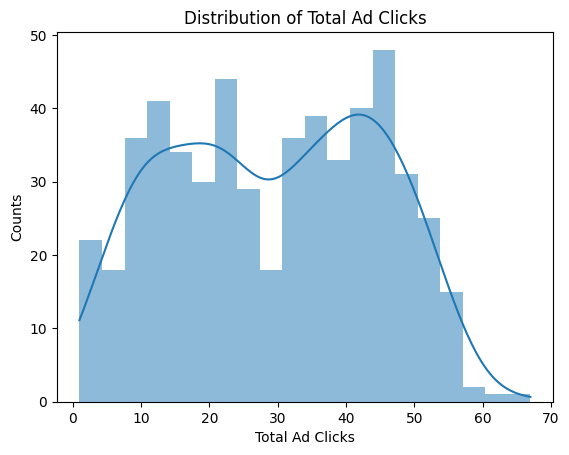

In [ ]:
# Visualize totalAdClicks

# Extract the values from the 'totalAdClicks' column into a list
total_ad_clicks = [row['totalAdClicks'] for row in p_df.select('totalAdClicks').collect()]

# Plot a histogram
sns.histplot(total_ad_clicks, kde=True, bins=20, edgecolor='none')

plt.xlabel('Total Ad Clicks')
plt.ylabel('Counts')
plt.title('Distribution of Total Ad Clicks')
plt.show()


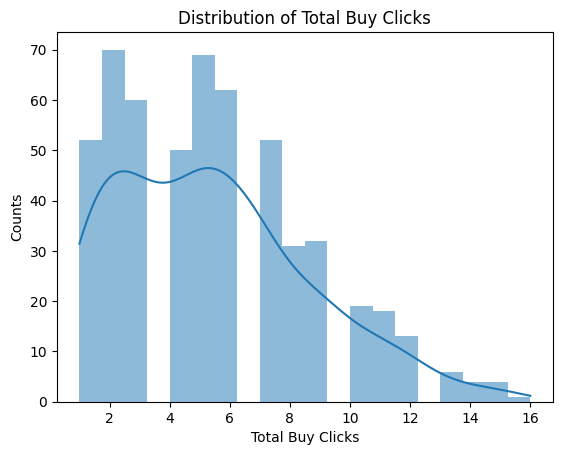

In [ ]:
## Visualize totalGameClicks

# Extract the values from the 'totalBuyClicks' column into a list
total_ad_clicks = [row['totalBuyClicks'] for row in p_df.select('totalBuyClicks').collect()]

# Plot a histogram
sns.histplot(total_ad_clicks, kde=True, bins=20, edgecolor='none')

plt.xlabel('Total Buy Clicks')
plt.ylabel('Counts')
plt.title('Distribution of Total Buy Clicks')
plt.show()


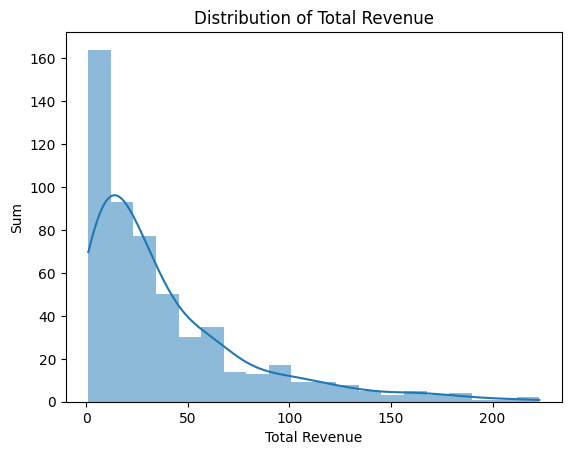

In [ ]:
## Visualize revenue

# Extract the values from the 'revenue' column into a list
total_ad_clicks = [row['totalRevenue'] for row in p_df.select('totalRevenue').collect()]

# Plot a histogram
sns.histplot(total_ad_clicks, kde=True, bins=20, edgecolor='none')

plt.xlabel('Total Revenue')
plt.ylabel('Sum')
plt.title('Distribution of Total Revenue')
plt.show()


In [ ]:
from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(
    inputCols= p_df.columns,
    outputCol= 'features'
)

final_df = vec_assembler.transform(p_df)
final_df.show(3)


+-------------+--------------+------------+---------------+
|totalAdClicks|totalBuyClicks|totalRevenue|       features|
+-------------+--------------+------------+---------------+
|           44|             9|        21.0|[44.0,9.0,21.0]|
|           10|             5|        53.0|[10.0,5.0,53.0]|
|           37|             6|        80.0|[37.0,6.0,80.0]|
+-------------+--------------+------------+---------------+
only showing top 3 rows



In [ ]:
# Scale dû liêu
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledfeatures", withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_df)

# Normalize each feature to have unit standard deviation.
final_df = scalerModel.transform(final_df)

final_df.show(3, False)


+-------------+--------------+------------+---------------+----------------------------------------------------------+
|totalAdClicks|totalBuyClicks|totalRevenue|features       |scaledfeatures                                            |
+-------------+--------------+------------+---------------+----------------------------------------------------------+
|44           |9             |21.0        |[44.0,9.0,21.0]|[2.8916277306528366,2.773742730924697,0.5094399617040963] |
|10           |5             |53.0        |[10.0,5.0,53.0]|[0.6571881206029174,1.540968183847054,1.2857294271579576] |
|37           |6             |80.0        |[37.0,6.0,80.0]|[2.4315960462307946,1.8491618206164648,1.9407236636346528]|
+-------------+--------------+------------+---------------+----------------------------------------------------------+
only showing top 3 rows



In [ ]:
# Trains a k-means model.
k_list = []
silhouette_list = []

sil_str = ""

for k in range(2,11):
  kmeans = KMeans(featuresCol='scaledfeatures', k=k)
  model = kmeans.fit(final_df)
  k_list.append(k)

  # silhoutte
  predictions = model.transform(final_df)
  # Evaluate clustering by computing silhouette score
  evaluator = ClusteringEvaluator()
  silhouette = evaluator.evaluate(predictions)
  silhouette_list.append(silhouette)
  
  sil_str = sil_str + "with k =" + str(k) + "- Silhouette = " + str(silhouette) + "\n"

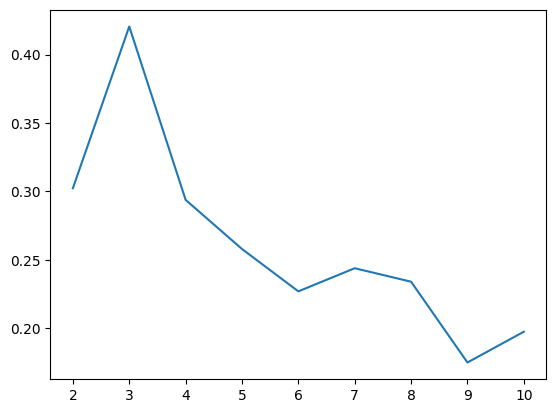

In [ ]:
### Xây dung model (tt)
plt.plot(k_list, silhouette_list)
plt.show()

In [ ]:
print(sil_str)

with k =2- Silhouette = 0.30236361690158936
with k =3- Silhouette = 0.42048541859166605
with k =4- Silhouette = 0.2938381061458972
with k =5- Silhouette = 0.2579554676414119
with k =6- Silhouette = 0.22700760875124823
with k =7- Silhouette = 0.24390915236279676
with k =8- Silhouette = 0.2340660371774309
with k =9- Silhouette = 0.17506646883252616
with k =10- Silhouette = 0.1975148772500091



In [ ]:
final_df.show(3)

+-------------+--------------+------------+---------------+--------------------+
|totalAdClicks|totalBuyClicks|totalRevenue|       features|      scaledfeatures|
+-------------+--------------+------------+---------------+--------------------+
|           44|             9|        21.0|[44.0,9.0,21.0]|[2.89162773065283...|
|           10|             5|        53.0|[10.0,5.0,53.0]|[0.65718812060291...|
|           37|             6|        80.0|[37.0,6.0,80.0]|[2.43159604623079...|
+-------------+--------------+------------+---------------+--------------------+
only showing top 3 rows



In [ ]:
### Xay dung model
# Trains a k-means model.
kmeans = KMeans(featuresCol='scaledfeatures', k=3, maxIter=20, initMode="random")
model = kmeans.fit(final_df.select("scaledfeatures"))

In [ ]:
# silhoutte
predictions = model.transform(final_df)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("silhoutte = " + str(silhouette))

silhoutte = 0.42709571617585596


In [ ]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
  print(center)

Cluster Centers: 
[1.04917237 0.91123394 0.4968329 ]
[2.69036387 2.96636375 3.15291786]
[2.70907547 2.15872521 0.8460477 ]


In [ ]:
## Du doán kêt quá
predictions = model.transform(final_df)


In [ ]:
# predictions.select("prediction").show(5)
predictions.show(5)

+-------------+--------------+------------+-----------------+--------------------+----------+
|totalAdClicks|totalBuyClicks|totalRevenue|         features|      scaledfeatures|prediction|
+-------------+--------------+------------+-----------------+--------------------+----------+
|           44|             9|        21.0|  [44.0,9.0,21.0]|[2.89162773065283...|         2|
|           10|             5|        53.0|  [10.0,5.0,53.0]|[0.65718812060291...|         0|
|           37|             6|        80.0|  [37.0,6.0,80.0]|[2.43159604623079...|         2|
|           19|            10|        11.0| [19.0,10.0,11.0]|[1.24865742914554...|         2|
|           46|            13|       215.0|[46.0,13.0,215.0]|[3.02306535477342...|         1|
+-------------+--------------+------------+-----------------+--------------------+----------+
only showing top 5 rows



In [ ]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   64|
|         2|  225|
|         0|  254|
+----------+-----+



In [ ]:
### Du doán kêt qua (tt)
final_df.show(3, False)


+-------------+--------------+------------+---------------+----------------------------------------------------------+
|totalAdClicks|totalBuyClicks|totalRevenue|features       |scaledfeatures                                            |
+-------------+--------------+------------+---------------+----------------------------------------------------------+
|44           |9             |21.0        |[44.0,9.0,21.0]|[2.8916277306528366,2.773742730924697,0.5094399617040963] |
|10           |5             |53.0        |[10.0,5.0,53.0]|[0.6571881206029174,1.540968183847054,1.2857294271579576] |
|37           |6             |80.0        |[37.0,6.0,80.0]|[2.4315960462307946,1.8491618206164648,1.9407236636346528]|
+-------------+--------------+------------+---------------+----------------------------------------------------------+
only showing top 3 rows



In [ ]:
temp = final_df.select("features").rdd.map(lambda x: x[0].toArray().tolist()).toDF()
temp.show(3)

+----+---+----+
|  _1| _2|  _3|
+----+---+----+
|44.0|9.0|21.0|
|10.0|5.0|53.0|
|37.0|6.0|80.0|
+----+---+----+
only showing top 3 rows



In [ ]:
data_result = predictions.select('prediction')
data_result.columns

['prediction']

In [ ]:
temp.show(3)

+----+---+----+
|  _1| _2|  _3|
+----+---+----+
|44.0|9.0|21.0|
|10.0|5.0|53.0|
|37.0|6.0|80.0|
+----+---+----+
only showing top 3 rows



In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

In [ ]:
### Du doán kêt qua (tt)
temp = temp.withColumn('row_index', monotonically_increasing_id())
data_result = data_result.withColumn('row_index', monotonically_increasing_id())
temp = temp.join(data_result, on=["row_index"]).sort("row_index").drop("row_index")
temp.show(5)


+----+----+-----+----------+
|  _1|  _2|   _3|prediction|
+----+----+-----+----------+
|44.0| 9.0| 21.0|         2|
|10.0| 5.0| 53.0|         0|
|37.0| 6.0| 80.0|         2|
|19.0|10.0| 11.0|         2|
|46.0|13.0|215.0|         1|
+----+----+-----+----------+
only showing top 5 rows



In [ ]:
## Truc quan hóa dû liêu
df = temp.toPandas()
df=df.rename(columns={"_1": "totalAdClicks", "_2": "totalBuyClicks", "_3":"totalRevenue", 'prediction':'prediction'})
df.head()


,totalAdClicks,totalBuyClicks,totalRevenue,prediction
0,44.0,9.0,21.0,2
1,10.0,5.0,53.0,0
2,37.0,6.0,80.0,2
3,19.0,10.0,11.0,2
4,46.0,13.0,215.0,1


In [ ]:
centers_df = pd.DataFrame(centers)
centers_df=centers_df.rename(columns={0: "totalAdClicks", 1: "totalBuyClicks", 2:"totalRevenue"})
centers_df.head()


,totalAdClicks,totalBuyClicks,totalRevenue
0,1.049172,0.911234,0.496833
1,2.690364,2.966364,3.152918
2,2.709075,2.158725,0.846048


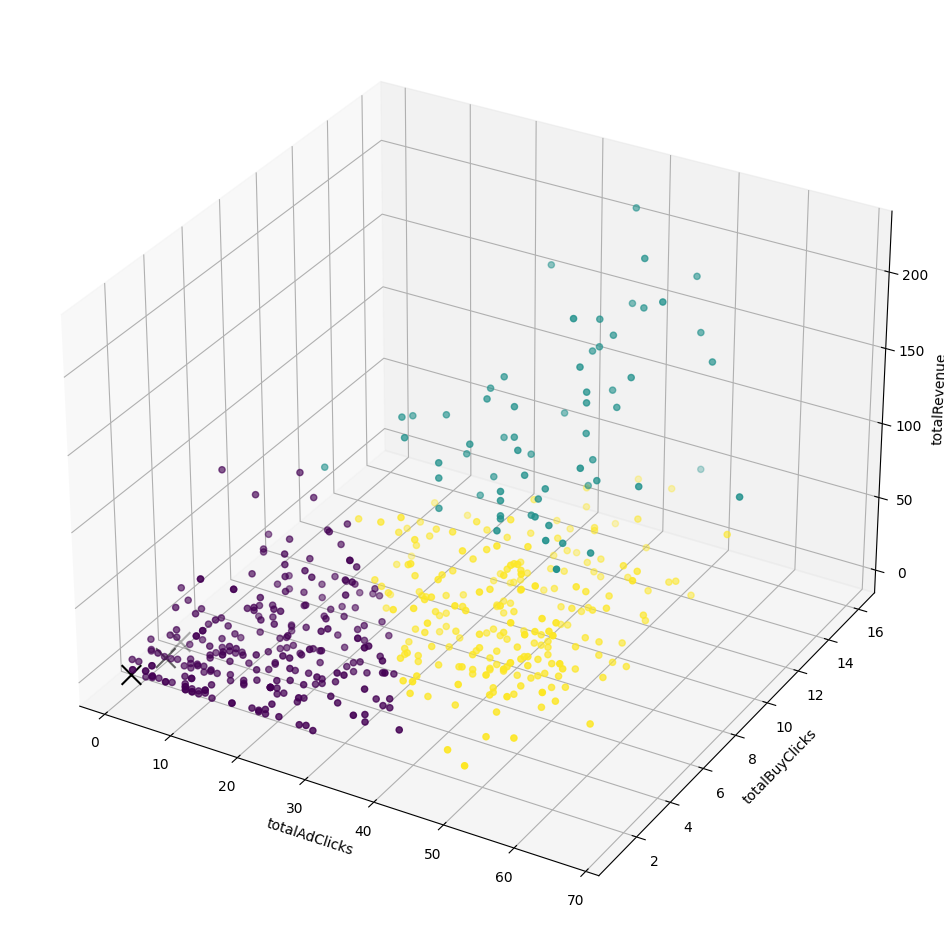

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=df['totalAdClicks'], ys=df['totalBuyClicks'], zs=df['totalRevenue'], c=df['prediction'])

ax.scatter(xs=centers_df['totalAdClicks'], ys=centers_df['totalBuyClicks'], zs=centers_df['totalRevenue'], marker='x', s=200, c='black')

ax.set_xlabel('totalAdClicks')
ax.set_ylabel('totalBuyClicks')
ax.set_zlabel('totalRevenue')

plt.show()


### Bar chart the centers of three clusters formed

In [ ]:
centers_df.head()

,totalAdClicks,totalBuyClicks,totalRevenue
0,1.049172,0.911234,0.496833
1,2.690364,2.966364,3.152918
2,2.709075,2.158725,0.846048


array([<Axes: title={'center': 'totalAdClicks'}>,
       <Axes: title={'center': 'totalBuyClicks'}>,
       <Axes: title={'center': 'totalRevenue'}>], dtype=object)

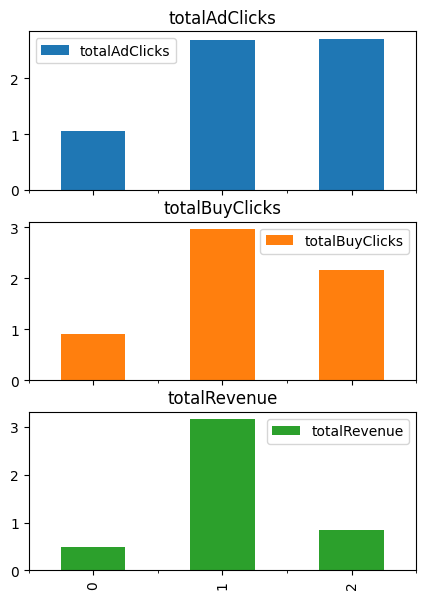

In [ ]:
%matplotlib inline
centers_df.plot(kind='bar',subplots=True, figsize=(5,7), use_index=True)